This notebook finetunes a pretrained vision transformer ViT-B/16 model on the CIFAR-10 dataset. The final accuracy is 97.42%.

In [1]:
import os
import sys
import time
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnchoredOffsetbox
from tqdm import tqdm # progress bar

sys.path.append('../../../src')

## some parameters

In [2]:
batch_size = 32 # can be set small for stronger regularization from batchnorm, and also saves memory.
learning_rate = 2e-5
weight_decay = 0.01
epochs = 15

## only use dataset and dataloader from pytorch
tensors loaded using `pytorch` will be converted to `tortto` tensors later.

In [3]:
from numpy.random import choice
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Resize, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Normalize

In [4]:
dataset_path = '../../cifar10_data'
img_mean = (.5,.5,.5)
img_sd = (.5,.5,.5)
transform_aug = Compose([
    RandomResizedCrop((224, 224)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(img_mean, img_sd),
])
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(img_mean, img_sd)
])
# create datasets
train_dataset = CIFAR10(root=dataset_path, train=True, download=True, transform=transform_aug)
val_dataset = CIFAR10(root=dataset_path, train=True, download=True, transform=transform)
test_dataset = CIFAR10(root=dataset_path, train=False, download=True, transform=transform)

# create dataloaders
indices = choice(50_000, size=50_000, replace=False)
train_idx, val_idx, _ = indices[:45_00], indices[45_00:50_00], indices[50_00:] # we only use 1/10th of train data
train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # test data is untouched

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('size of train set', len(train_idx))
print('size of validation set', len(val_idx))
print('size of test set', len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
size of train set 4500
size of validation set 500
size of test set 10000


## the rest is done in pytortto

In [5]:
import tortto as tt
import tortto.nn as nn
import tortto.nn.functional as F
import tortto.optim as optim

## define a network

In [6]:
class VisionTransformer_finetune(nn.Module):
    def __init__(self, image_size, patch_size, embed_dim, hidden_dim, in_channels, num_heads, num_layers, num_classes,
                 dropout):
        H, W = image_size
        ph, pw = patch_size
        num_patches = int(((H + 0.1) // ph) * ((W + 0.1) // pw))
        super(VisionTransformer_finetune, self).__init__()
        self.input_layer = nn.Conv2d(in_channels, embed_dim, patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(tt.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(tt.randn(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, hidden_dim, dropout, activation=F.gelu,
                                                   batch_first=True, norm_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers, norm=nn.LayerNorm(embed_dim))
        

    def forward(self, x):  # B: batchsize, C:in_channels, E:embedding dim
        x = self.input_layer(x).flatten(-2, -1).swapaxes(-1, -2)  # B,C,H,W, -> B,E,h,w -> B,E,h*w -> B,h*w,E
        B, N = x.shape[:2]  # batch and number of patches
        x = tt.cat([self.cls_token.repeat(B, 1, 1), x], dim=1)  # add class token
        x = x + self.pos_embedding[:, :(N + 1)]  # add position embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = F.log_softmax(self.classifier(x[:, 0]), dim=-1)
        return x

In [7]:
kwargs={
    # CIFAR-10
    'image_size':(224,224), # (3,32,32) resized to (3,224,224)
    'in_channels':3,
    'num_classes':10,
    
    # ViT-Base
    'patch_size':(16,16),
    'embed_dim':768,
    'hidden_dim':3072,
    'num_heads':12,
    'num_layers':12,
    'dropout':0.,
}

# initialize a ViT
net = VisionTransformer_finetune(**kwargs)

# load pretrained parameters
net.load_state_dict(tt.load('models/vit-base-patch16-224-in21k.npy'))

# add an extra classification layer
net.classifier = nn.Linear(kwargs['embed_dim'], kwargs['num_classes']) # add extra classfication layer
nn.init.zeros_(net.classifier.bias)

# total parameters
print(f'total trainable parameters: {sum(_.numel() for _ in net.parameters())/1e6:.2f} million')


net = net.cuda()
criterion = nn.NLLLoss()
optimizer = optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

total trainable parameters: 85.81 million


## define functions for training and validation

In [8]:
def calculate_loss(batch, correct, total):
    inputs, labels = batch
    
    # convert pytorch tensor to tortto tensor
    inpt = tt.tensor(inputs.numpy()).cuda()
    lab = tt.tensor(labels.numpy()).cuda()
    
    # forward
    outputs = net(inpt)
    loss = criterion(outputs, lab)
    
    # prediction
    predicted = outputs.argmax(-1)
    correct += (predicted == lab).sum().item()
    total += lab.shape[0]
    
    return loss, correct, total
    
    
def train():
    # train
    net.train()
    correct = 0
    total = 0
    loop = tqdm(train_loader)
    train_loss = 0
    for i, batch in enumerate(loop):

        # zero the parameter gradients
        optimizer.zero_grad()

        loss, correct, total = calculate_loss(batch, correct, total)
        
        # accumulate loss
        train_loss += loss.item()

        # backpropagation
        loss.backward()

        # update parameters
        optimizer.step()

    # keep track of train loss and train error
    loss_history['train'].append(train_loss / (i + 1))
    error_history['train'].append(100 * (1. - correct / total))
    

@tt.no_grad()
def val_test(dataloader):
    net.eval()
    correct = 0
    total_sample = 0
    total_loss = 0
    loop = tqdm(dataloader)
    for i, batch in enumerate(loop):
        
        # cal loss
        loss, correct, total_sample = calculate_loss(batch, correct, total_sample)
        
        # accumulate val loss
        total_loss += loss.item()
    
    avg_loss = total_loss / (i + 1)
    avg_error = 100 * (1. - correct / total_sample)
    return avg_loss, avg_error

    
def save():
    global lowest_error
    # save checkpoint
    if error_history['val'][-1] < lowest_error:
        checkpoint = {
            'model': net.state_dict()
            }
        tt.save(checkpoint, f'models/checkpoint_{str(epoch).zfill(3)}.npy')
        lowest_error = error_history['val'][-1]
    
    # save loss, error history and log
    tt.save(loss_history, 'logs/loss_history.npy')
    tt.save(error_history, 'logs/error_history.npy')
    with open('logs/log.txt','a') as f:
        f.write('epoch{} finished at {}. val_loss: {:.4f} - val_error: {:.2f}%\n'.
                format(str(epoch).zfill(3), 
                       datetime.now().strftime("%m/%d/%Y, %H:%M:%S"), 
                       loss_history['val'][-1], 
                       error_history['val'][-1]))

## start training

In [9]:
loss_history = {'train': [], 'val': []}
error_history = {'train': [], 'val': []}

if os.path.exists('logs/log.txt'):
    raise OSError('log.txt already exists')

lowest_error = 100
warmup=1
for epoch in range(epochs):
    if epoch < warmup:
        optimizer.param_groups[0]['lr'] = learning_rate / 10
    elif epoch == warmup:
        optimizer.param_groups[0]['lr'] = learning_rate
    
    # train
    train()
    
    # validation
    val_loss, val_error = val_test(val_loader)
    loss_history['val'].append(val_loss)
    error_history['val'].append(val_error)
    print(' - val_loss: {:.4f} - val_error: {:.2f}%\n'.format(loss_history['val'][-1], val_error))
    
    # save
    save()

100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


 - val_loss: 2.2198 - val_error: 67.40%



100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


 - val_loss: 0.8720 - val_error: 5.20%



100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


 - val_loss: 0.4419 - val_error: 3.00%



100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


 - val_loss: 0.2966 - val_error: 2.00%



100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


 - val_loss: 0.2383 - val_error: 2.00%



100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


 - val_loss: 0.2018 - val_error: 2.40%



100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


 - val_loss: 0.1745 - val_error: 2.60%



100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


 - val_loss: 0.1600 - val_error: 2.40%



100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


 - val_loss: 0.1414 - val_error: 2.20%



100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


 - val_loss: 0.1287 - val_error: 2.80%



100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


 - val_loss: 0.1152 - val_error: 2.00%



100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


 - val_loss: 0.1136 - val_error: 2.00%



100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


 - val_loss: 0.0967 - val_error: 1.80%



100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


 - val_loss: 0.1125 - val_error: 2.60%



100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


 - val_loss: 0.1019 - val_error: 1.60%



## plot loss and error

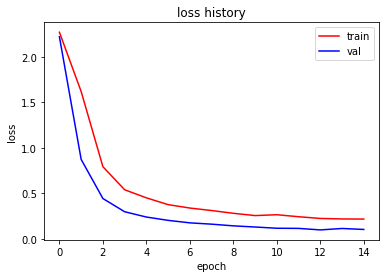

In [10]:
loss_history = tt.load('logs/loss_history.npy')
plt.plot(loss_history['train'], 'r', label='train')
plt.plot(loss_history['val'], 'b', label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss history')
plt.legend()
plt.show()

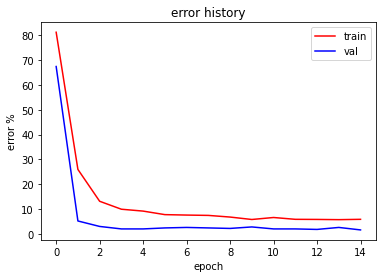

In [11]:
error_history = tt.load('logs/error_history.npy')
plt.plot(error_history['train'], 'r', label='train')
plt.plot(error_history['val'], 'b', label='val')
plt.xlabel('epoch')
plt.ylabel('error %')
plt.title('error history')
plt.legend()
plt.show()

## evaluation on test set

In [12]:
# load checkpoint with the lowest validation error
checkpoint = tt.load('models/checkpoint_014.npy')
net.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [13]:
_, test_error = val_test(test_loader)
print(f'Test error: {test_error:.2f}%')

100%|██████████| 313/313 [03:01<00:00,  1.72it/s]

Test error: 2.58%
